# 프로젝트: 고양이 수염 만들기

In [1]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 
import math # 각도 계산을 위해 임포트

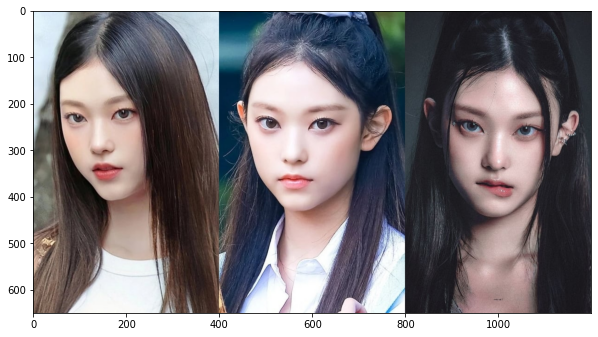

In [2]:
my_image_path = 'haerin3.jpeg' # 이미지 경로
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지를 불러오기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 채널 변환

plt.figure(figsize=(10,10))
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (실제 출력은 아님)
plt.show() # 이미지 실제 출력

In [3]:
# face detector 선언
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(438, 171) (706, 439)], [(43, 167) (266, 390)], [(885, 192) (1108, 415)]]


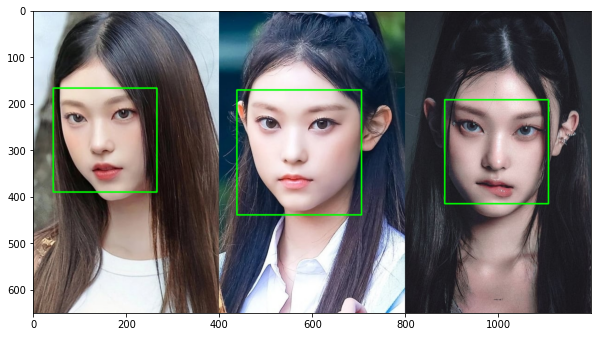

In [4]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()

In [5]:
# landmark 모델 불러오기
model_path = 'models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
- landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
- dlib.rectangle: 내부를 예측하는 박스
- dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [6]:
# 랜드마크의 위치를 저장할 list 생성    
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아내고 좌표 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장


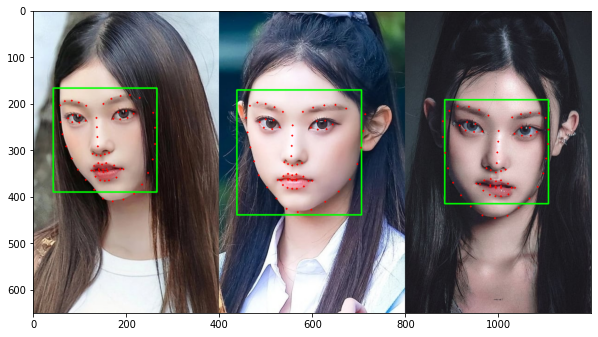

In [7]:
# landmark 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 2, (255, 0, 0), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
            
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()

In [8]:
# 스티커 이미지 불러오기
sticker_path = 'cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker.shape

(512, 512, 3)

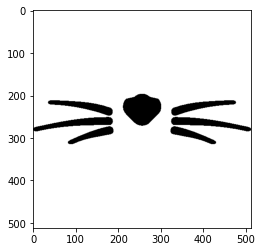

In [9]:
plt.imshow(img_sticker)
plt.show()

- 수염의 위치가 프레임 밖을 넘어가는 경우를 따로 처리해줘야 한다. 
- 5번 노드에서는 프레임 왼쪽/위쪽으로 넘어간 경우만 해결했는데, 추가로 오른쪽/아래쪽으로 넘어간 경우를 해결해야 한다.
- 이 경우는 스티커 이미지 시작점(이미지의 좌상단 꼭짓점)의 좌표에서 스티커 이미지 넓이/높이를 더했을 때 전체 프레임 크기보다 큰 경우에 해당한다.
- 프레임 밖으로 넘어간 부분을 크롭해주는 코드 추가.

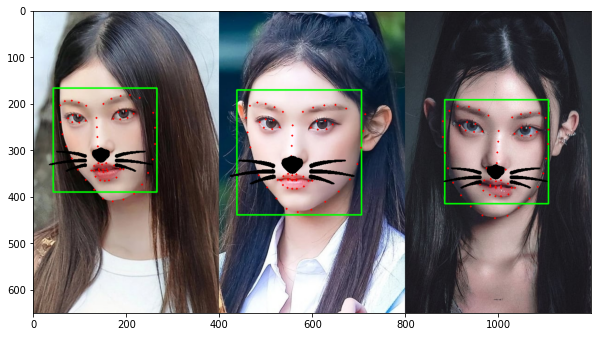

In [10]:
# 수염 그리기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    # 이미지 중심점 잡기
    center = ((landmark[33][0] + landmark[51][0]) // 2, (landmark[33][1] + landmark[51][1]) // 2)
    x = center[0] # 이미지에서 코 부위의 x값
    y = center[1]
    w = dlib_rect.width() 
    h = w
    img_sticker_resize = cv2.resize(img_sticker, (w,h))
    
    # 이미지 시작점 잡기
    ref_x = x - w//2
    ref_y = y - h//2
    
    # 코너 케이스 - 좌표가 음수일 때
    if ref_x < 0: 
        img_sticker_resize = img_sticker_resize[:, -ref_x:]
        ref_x = 0
    if ref_y < 0:
        img_sticker_resize = img_sticker_resize[-ref_y:, :] 

    # 코너 케이스 - 시작점 + 스티커 크기가 원본을 넘어갈 때
    if ref_x + w > img_rgb.shape[1]:
        img_sticker_resize = img_sticker_resize[:, :-(ref_x + w - img_rgb.shape[1])]

    if ref_y + h > img_rgb.shape[0]:
        img_sticker_resize = img_sticker_resize[:-(ref_y + h - img_rgb.shape[0])]

    sticker_area = img_rgb[ref_y:min(ref_y+img_sticker_resize.shape[0], img_rgb.shape[0]), ref_x:min(ref_x+img_sticker_resize.shape[1], img_rgb.shape[1])]
    img_rgb[ref_y:ref_y+img_sticker_resize.shape[0], ref_x:ref_x+img_sticker_resize.shape[1]] = \
        np.where(img_sticker_resize==0, img_sticker_resize, sticker_area).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()

In [11]:
# 위 코드를 함수화
def draw_cat_whiskers(img_path, sticker_path='cat-whiskers.png'):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    img_sticker = cv2.imread(sticker_path)
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
        center = ((landmark[33][0] + landmark[51][0]) // 2, (landmark[33][1] + landmark[51][1]) // 2)
        x = center[0]
        y = center[1]
        w = dlib_rect.width() 
        h = w
        img_sticker_resize = cv2.resize(img_sticker, (w,h))

        ref_x = x - w//2
        ref_y = y - h//2
        
        # 코너 케이스 - 기준점 좌표가 음수일 때
        if ref_x < 0: 
            img_sticker_resize = img_sticker_resize[:, -ref_x:]
            ref_x = 0
        if ref_y < 0:
            img_sticker_resize = img_sticker_resize[-ref_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
            ref_y = 0

        # 코너 케이스 - 시작점 + 스티커 크기가 원본을 넘어갈 때
        if ref_x + w > img_rgb.shape[1]:
            img_sticker_resize = img_sticker_resize[:, :-(ref_x + w - img_rgb.shape[1])]
            
        if ref_y + h > img_rgb.shape[0]:
            img_sticker_resize = img_sticker_resize[:-(ref_y + h - img_rgb.shape[0])]

        sticker_area = img_rgb[ref_y:min(ref_y+img_sticker_resize.shape[0], img_rgb.shape[0]), ref_x:min(ref_x+img_sticker_resize.shape[1], img_rgb.shape[1])]
        img_rgb[ref_y:ref_y+img_sticker_resize.shape[0], ref_x:ref_x+img_sticker_resize.shape[1]] = \
            np.where(img_sticker_resize==0, img_sticker_resize, sticker_area).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.imshow(img_rgb)
    plt.show()
    
    # 이미지 저장 기능 추가
    save_path = img_path.split('.')[0] + '_whskers.png'
    img_final = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    img_final = cv2.imwrite(save_path, img_final)
    
    

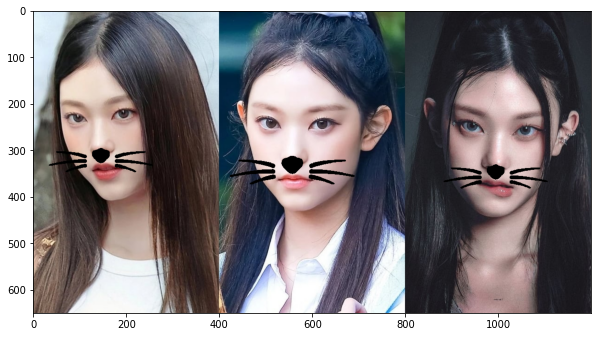

In [12]:
draw_cat_whiskers('haerin3.jpeg')

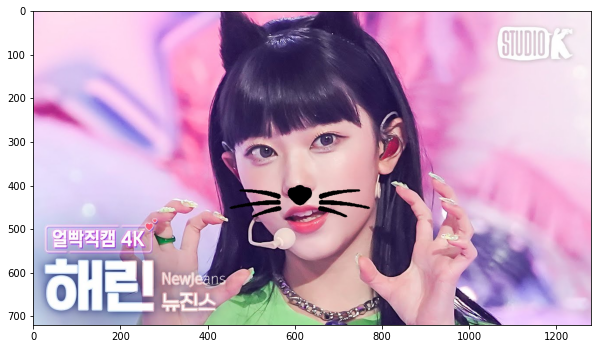

In [13]:
draw_cat_whiskers('haerin.jpeg')

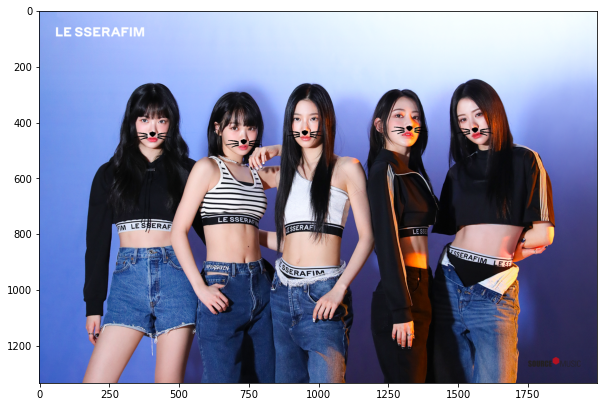

In [14]:
draw_cat_whiskers('lesserafim.jpeg')

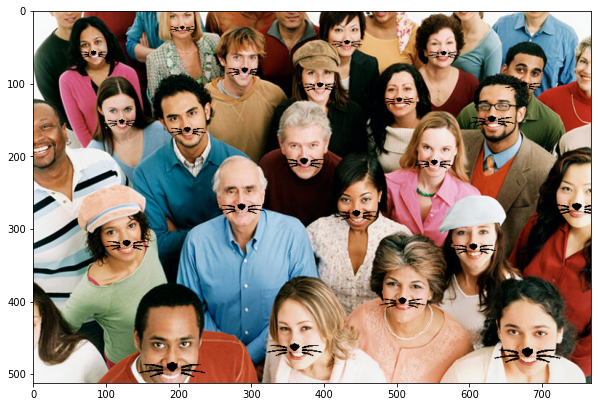

In [15]:
draw_cat_whiskers('crowd.jpeg')

### 개선점: 얼굴 각도에 따라 수염을 회전시키자!

- math.atan2 이용하여 얼굴의 회전 각도를 계산할 수 있다.
- 이미지를 90도 단위로 회전하지 않는다면 이미지 모양과 직사각형 프레임이 들어맞지 않는 부분이 까맣게 표시된다. 스티커 이미지가 흑백((0,0,0) 혹은 (255,255,255))임을 이용하여 다음과 같은 과정으로 검은 여백을 제거한다.
    - 수염 부분은 모든 채널에서 값이 0, 배경 부분은 255로 되어있다.
    - 수염 부분의 값을 1로 변경
    - 회전 후 생기는 검은 여백은 값이 0으로 되어있다(즉, 수염과 구분된다. 위에서 수염 부분 값을 1로 바꿔준 이유가 이것이다.). 이 0을 255로 변경하면 검은 여백이 흰 배경으로 바뀐다.
    - 수염 부분의 값을 다시 1에서 0으로 변경
  

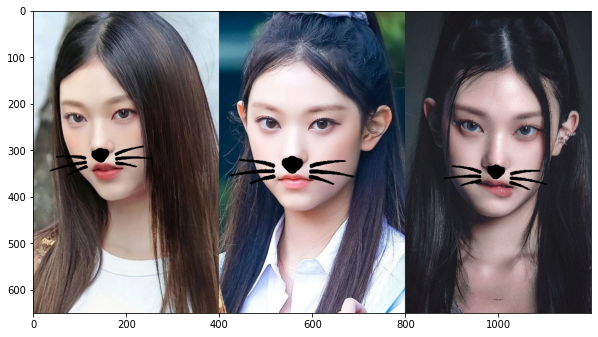

In [16]:
# 수염 그리기 -> 수염 회전 기능 추가
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 채널 변환

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    # 얼굴 각도 계산
    x_27 = landmark[27][0]
    y_27 = landmark[27][1]
    x_33 = landmark[33][0]
    y_33 = landmark[33][1]
    x_51 = landmark[51][0]
    y_51 = landmark[51][1]
    theta = - 90 - math.atan2(y_27 - y_51, x_27 - x_51) * 180 / math.pi 

    # 이미지 중심점 잡기
    center = ((x_33 + x_51) // 2, (y_33 + y_51) // 2)
    x = center[0]
    y = center[1]
    w = dlib_rect.width() 
    h = w
    
    # 이미지 리사이즈, 회전 (+ 회전 후 생기는 검은 여백 제거 작업까지)
    img_sticker = cv2.imread(sticker_path)
    rot_mat = cv2.getRotationMatrix2D((img_sticker.shape[1] / 2, img_sticker.shape[0] / 2), theta, 1)
    img_sticker = np.where(img_sticker == 0, 1, 255).astype(np.uint8)
    img_sticker_rotate = cv2.warpAffine(img_sticker, rot_mat, (img_sticker.shape[1], img_sticker.shape[0]))
    img_sticker_rotate = np.where(img_sticker_rotate==0, 255, img_sticker_rotate).astype(np.uint8)
    img_sticker_rotate = np.where(img_sticker_rotate==1, 0, 255).astype(np.uint8)
    img_sticker_resize = cv2.resize(img_sticker_rotate, (w,h))

    
    # 이미지 시작점 잡기
    ref_x = x - w//2
    ref_y = y - h//2
    
    # 코너 케이스 - 좌표가 음수일 때
    if ref_x < 0: 
        img_sticker_resize = img_sticker_resize[:, -ref_x:]
        ref_x = 0
    if ref_y < 0:
        img_sticker_resize = img_sticker_resize[-ref_y:, :] 

    # 코너 케이스 - 시작점 + 스티커 크기가 원본을 넘어갈 때
    if ref_x + w > img_rgb.shape[1]:
        img_sticker_resize = img_sticker_resize[:, :-(ref_x + w - img_rgb.shape[1])]

    if ref_y + h > img_rgb.shape[0]:
        img_sticker_resize = img_sticker_resize[:-(ref_y + h - img_rgb.shape[0])]

    sticker_area = img_rgb[ref_y:min(ref_y+img_sticker_resize.shape[0], img_rgb.shape[0]), ref_x:min(ref_x+img_sticker_resize.shape[1], img_rgb.shape[1])]
    img_rgb[ref_y:ref_y+img_sticker_resize.shape[0], ref_x:ref_x+img_sticker_resize.shape[1]] = \
        np.where(img_sticker_resize==0, img_sticker_resize, sticker_area).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)

plt.show()

In [17]:
# 회전 기능 및 수염 크기 확대/축소 기능 추가한 함수
def draw_cat_whiskers_rot_scale(img_path, sticker_path='cat-whiskers.png', scale=1):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    img_sticker = cv2.imread(sticker_path)
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
        # 얼굴 각도 계산
        x_27 = landmark[27][0]
        y_27 = landmark[27][1]
        x_33 = landmark[33][0]
        y_33 = landmark[33][1]
        x_51 = landmark[51][0]
        y_51 = landmark[51][1]
        theta = - 90 - math.atan2(y_27 - y_51, x_27 - x_51) * 180 / math.pi 

        # 이미지 중심점 잡기
        center = ((x_33 + x_51) // 2, (y_33 + y_51) // 2)
        x = center[0]
        y = center[1]
        w = dlib_rect.width() 
        h = w

        # 이미지 리사이즈, 회전 (+ 회전 후 생기는 검은 여백 제거 작업까지), 수염 스케일링
        img_sticker = cv2.imread(sticker_path)
        rot_mat = cv2.getRotationMatrix2D((img_sticker.shape[1] / 2, img_sticker.shape[0] / 2), theta, scale)
        img_sticker = np.where(img_sticker == 0, 1, 255).astype(np.uint8)
        img_sticker_rotate = cv2.warpAffine(img_sticker, rot_mat, (img_sticker.shape[1], img_sticker.shape[0]))
        img_sticker_rotate = np.where(img_sticker_rotate==0, 255, img_sticker_rotate).astype(np.uint8)
        img_sticker_rotate = np.where(img_sticker_rotate==1, 0, 255).astype(np.uint8)
        img_sticker_resize = cv2.resize(img_sticker_rotate, (w,h))


        ref_x = x - w//2
        ref_y = y - h//2
        
        # 코너 케이스 - 기준점 좌표가 음수일 때
        if ref_x < 0: 
            img_sticker_resize = img_sticker_resize[:, -ref_x:]
            ref_x = 0
        if ref_y < 0:
            img_sticker_resize = img_sticker_resize[-ref_y:, :] 
            ref_y = 0

        # 코너 케이스 - 시작점 + 스티커 크기가 원본을 넘어갈 때
        if ref_x + w > img_rgb.shape[1]:
            img_sticker_resize = img_sticker_resize[:, :-(ref_x + w - img_rgb.shape[1])]
            
        if ref_y + h > img_rgb.shape[0]:
            img_sticker_resize = img_sticker_resize[:-(ref_y + h - img_rgb.shape[0])]

        sticker_area = img_rgb[ref_y:min(ref_y+img_sticker_resize.shape[0], img_rgb.shape[0]), ref_x:min(ref_x+img_sticker_resize.shape[1], img_rgb.shape[1])]
        img_rgb[ref_y:ref_y+img_sticker_resize.shape[0], ref_x:ref_x+img_sticker_resize.shape[1]] = \
            np.where(img_sticker_resize==0, img_sticker_resize, sticker_area).astype(np.uint8)
        
    plt.figure(figsize=(10,10))
    plt.imshow(img_rgb)
    plt.show()
    
    # 이미지 저장 기능 추가
    save_path = img_path.split('.')[0] + '_whskers.png'
    img_final = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    img_final = cv2.imwrite(save_path, img_final)
    
    

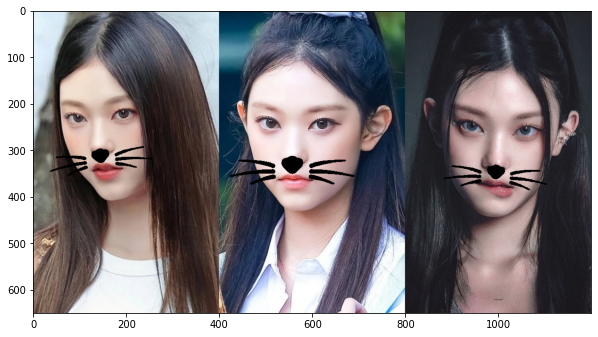

In [18]:
draw_cat_whiskers_rot_scale('haerin3.jpeg')

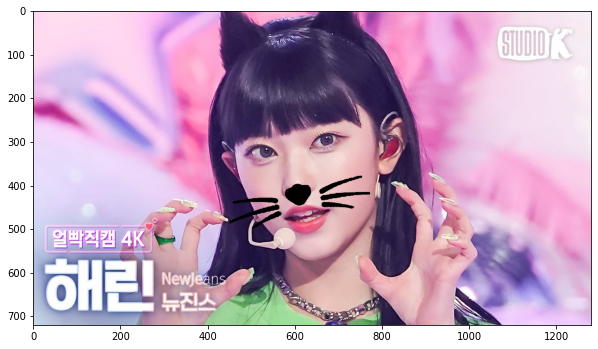

In [19]:
draw_cat_whiskers_rot_scale('haerin.jpeg', scale=1.1)

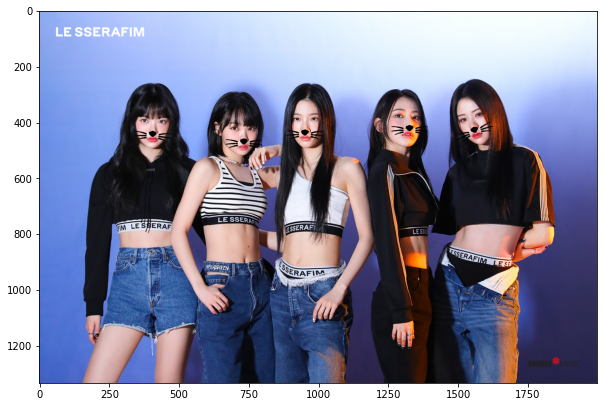

In [20]:
draw_cat_whiskers_rot_scale('lesserafim.jpeg', scale=1.2)

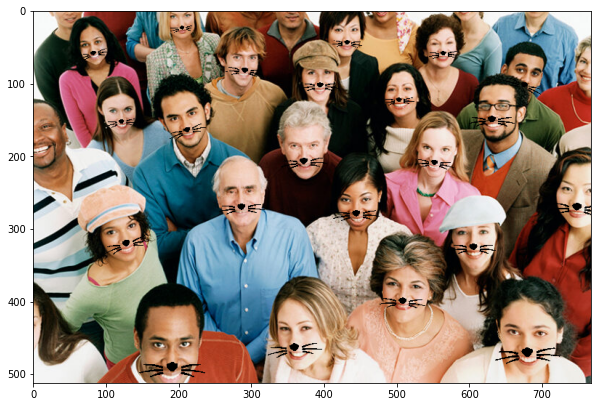

In [21]:
draw_cat_whiskers_rot_scale('crowd.jpeg')

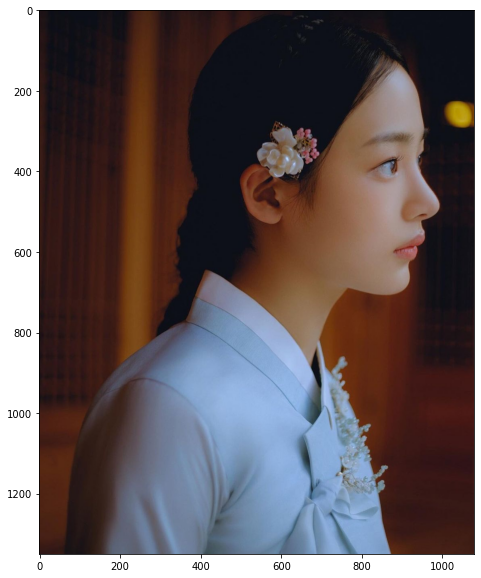

In [22]:
draw_cat_whiskers_rot_scale('minji.jpeg')

### 남아있는 문제점
- 위의 두 사진에서 볼 수 있듯이 얼굴의 일부분만 나오거나 옆모습이 나오는 경우 얼굴 인식이 되지 않는다.
- face detection 단계에서 개선이 필요하다.

## 회고
- 기존의 face detection 라이브러리를 이용해서 스티커를 자동으로 붙이는 서비스를 작성해봤는데, 이미 존재하는 모델을 이용해서 여러가지로 활용할 수 있을 것이라는 생각이 든다. 이를 위해서는 기존 라이브러리에 대한 설명을 잘 읽어보는 것이 중요하다.
- 예상치 못한 코너 케이스(스티커가 사진 밖으로 넘어가는 경우)를 미리 고려해야 실제 프로젝트를 진행할 때 에러를 방지할 수 있다.
- 라이브러리 자체를 수정할 수 있었으면 위에서 언급한 문제점을 해결할 수 있었을까? 더 공부해야 할 부분인 것 같다.